In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def load_csv(path):
    data = pd.read_csv(path, names = ['userId', 'movieId', 'rating', 'timestamp'], header = 0)
    
    # generate rating_matrix as R, transform it into a Numpy Array
    G = data.pivot_table(index = ['userId'], columns = ['movieId'], values = 'rating', fill_value = 0)
    R = data.pivot_table(index = ['userId'], columns = ['movieId'], values = 'rating', fill_value = 0).values
    return R, data,G

path = 'ml-latest-small/ratings.csv'
R, data, G = load_csv(path)
print (type(R))
print (R.shape)
movieids = G.axes[1]

total_users, total_movies = R.shape
total_valid_ratings = np.count_nonzero(R)
num_possible_ratings = total_users * total_movies

sparsity = total_valid_ratings / num_possible_ratings

print ('sparsity = ' + str(sparsity))

<class 'numpy.ndarray'>
(671, 9066)
sparsity = 0.016439141608663475


In [5]:
from surprise.prediction_algorithms.matrix_factorization import NMF
from surprise.model_selection import cross_validate
from surprise import Dataset
from surprise import Reader

path = 'ml-latest-small/ratings.csv'
reader = Reader(line_format='user item rating timestamp', sep=',', skip_lines=1)
data_nmf = Dataset.load_from_file(path, reader=reader)

print(1)
def cross_valid_nmf(data, k, name):
    rmse = [0]*25
    mae = [0]*25    
    for i in range(25):
        algo = eval(name)(n_factors = (i + 1) * 2)
        res = cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=k)
        rmse[i] = np.mean(res['test_rmse'])
        mae[i] = np.mean(res['test_mae'])
    return [rmse, mae]

res = cross_valid_nmf(data_nmf, 10,'NMF')
        


1


KeyboardInterrupt: 

[1.1771694848387804, 1.0690610177494844, 1.0103191414892843, 0.9745537489430557, 0.9587466620208588, 0.9473964302402772, 0.9414604949531433, 0.9385538994452236, 0.9372023279710688, 0.9388043737597302, 0.9427386541516631, 0.9458313826976585, 0.947660936666954, 0.949481153637616, 0.9552969649129084, 0.9571748495137958, 0.9617716054410582, 0.9678227801813865, 0.9703110413173652, 0.9728966996004976, 0.9767501278842167, 0.982409026605421, 0.9863080203804591, 0.9890915108710121, 0.9923150049296424]
[0.995727383203811, 0.8795346571285043, 0.813611209889092, 0.7714274935570741, 0.7500551531358254, 0.7351386993229239, 0.724663100097333, 0.7192829451561148, 0.7151945064711936, 0.7130841145374728, 0.7140822321250395, 0.715596999496673, 0.715519251700903, 0.7160472110933243, 0.7193899819232266, 0.7203012647915646, 0.7231773851600585, 0.728443135011469, 0.7296926063354942, 0.7316262237803742, 0.7337748130535375, 0.7375988159301513, 0.740291773036436, 0.74254099296386, 0.7454527505950225]


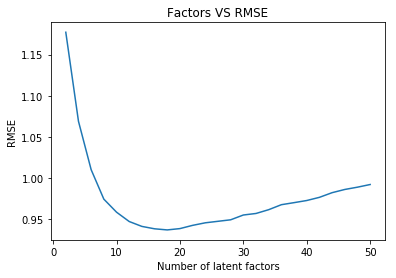

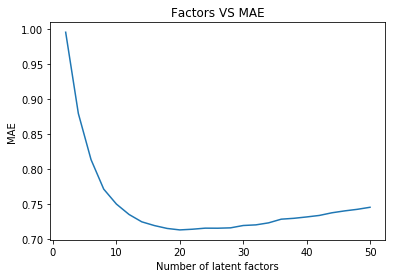

In [71]:
print(res[0])
print(res[1])

def plot_nmf(x,y,t,xval,yval):
    plt.xlabel(x)
    plt.ylabel(y)
    plt.title(t)
    plt.plot(xval, yval)
    plt.show()

plot_nmf('Number of latent factors', 'RMSE', 'Factors VS RMSE',np.linspace(2,50,25), res[0])
plot_nmf('Number of latent factors', 'MAE', 'Factors VS MAE', np.linspace(2,50,25), res[1])

#from the figures we are able to see that when category = 20
#we have the lowest rmse and mae value
#so what's the number of genres?
#RMSE 0.9372 when c = 18
#MAE 0.713 when c = 20
#we choose c = 20, the value of best categories is equal to the number of categories


In [86]:
from surprise.model_selection import KFold
from surprise import accuracy

def trim_set(testset):
    pop = set([])
    unpop = set([])
    highvar = set([])
    visited = set([])
    for item in testset:
        if item[1] not in visited:
            visited.add(item[1])
            scores = []
            count = 0            
            for subitem in testset: 
                if(subitem[1] == item[1]):
                    count = count + 1
                    scores.append(subitem[2])                
            if count <= 2:
                unpop.add(item[1])
            else:
                pop.add(item[1])
                if count >= 5 and np.var(np.array(scores) >= 2):                    
                    highvar.add(item[1])
    res1 = [item for item in testset if item[1] in pop]
    res2 = [item for item in testset if item[1] in unpop]
    res3 = [item for item in testset if item[1] in highvar]
    return [res1, res2, res3]    
    
def cross_valid_nmf_trim(data, k, name):
    kf = KFold(n_splits=k)
    rmse = np.array([[0.0]*3]*25)
    mae = np.array([[0.0]*3]*25)
    for i in range(25):
        print(i)
        algo = eval(name)(n_factors = (i + 1) * 2)
        rmse_cache = []
        mae_cache = []
        for trainset, testset in kf.split(data):
            algo.fit(trainset)
            trimed_set = trim_set(testset)
            pred1 = algo.test(trimed_set[0])
            pred2 = algo.test(trimed_set[1])
            pred3 = algo.test(trimed_set[2])
            rmse_cache.append([accuracy.rmse(pred1, verbose = False), accuracy.rmse(pred2, verbose = False), accuracy.rmse(pred3, verbose = False)])
            mae_cache.append([accuracy.mae(pred1, verbose = False), accuracy.mae(pred2, verbose = False), accuracy.mae(pred3, verbose = False)])
        rmse[i,:] = np.mean(np.array(rmse_cache), 0)
        mae[i,:] = np.mean(np.array(mae_cache), 0)
        print(rmse[i,:])
    return [rmse, mae]

res_trim = cross_valid_nmf_trim(data_nmf, 10, 'NMF')


0
[1.16622125 1.19929237 1.21164591]
1
[1.03957082 1.12815143 1.12210452]
2
[0.97127243 1.09521974 1.08454411]
3
[0.93071963 1.07039919 1.06209545]
4
[0.90994195 1.05708249 1.05443271]
5
[0.89591465 1.05467253 1.06242692]
6
[0.89458483 1.03608122 1.06831827]
7
[0.89034711 1.0364001  1.07272653]
8
[0.89364106 1.03190456 1.08324704]
9
[0.89534837 1.02918377 1.08934693]
10
[0.8986821  1.03426659 1.08556095]
11
[0.90439707 1.02890947 1.09911816]
12
[0.90802007 1.0333323  1.11752838]
13
[0.91155229 1.03958131 1.11929217]
14
[0.91648741 1.03291791 1.12751728]
15
[0.92206474 1.03388246 1.12992868]
16
[0.92856936 1.03980124 1.13805649]
17
[0.93518224 1.03671631 1.14678832]
18
[0.93890794 1.03997521 1.15077673]
19
[0.94053726 1.04761059 1.15328908]
20
[0.94717503 1.042455   1.1620138 ]
21
[0.95098653 1.0478545  1.16661728]
22
[0.95478203 1.0516769  1.17315275]
23
[0.96147117 1.04752176 1.17996333]
24
[0.96667434 1.05327738 1.18471857]


[1.16622125 1.03957082 0.97127243 0.93071963 0.90994195 0.89591465
 0.89458483 0.89034711 0.89364106 0.89534837 0.8986821  0.90439707
 0.90802007 0.91155229 0.91648741 0.92206474 0.92856936 0.93518224
 0.93890794 0.94053726 0.94717503 0.95098653 0.95478203 0.96147117
 0.96667434]
[1.19929237 1.12815143 1.09521974 1.07039919 1.05708249 1.05467253
 1.03608122 1.0364001  1.03190456 1.02918377 1.03426659 1.02890947
 1.0333323  1.03958131 1.03291791 1.03388246 1.03980124 1.03671631
 1.03997521 1.04761059 1.042455   1.0478545  1.0516769  1.04752176
 1.05327738]
[1.21164591 1.12210452 1.08454411 1.06209545 1.05443271 1.06242692
 1.06831827 1.07272653 1.08324704 1.08934693 1.08556095 1.09911816
 1.11752838 1.11929217 1.12751728 1.12992868 1.13805649 1.14678832
 1.15077673 1.15328908 1.1620138  1.16661728 1.17315275 1.17996333
 1.18471857]


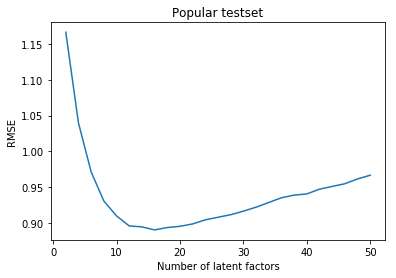

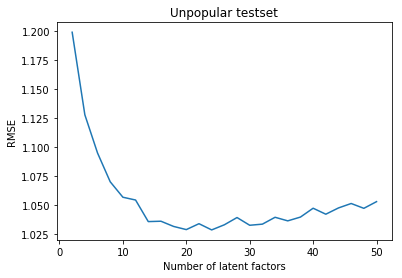

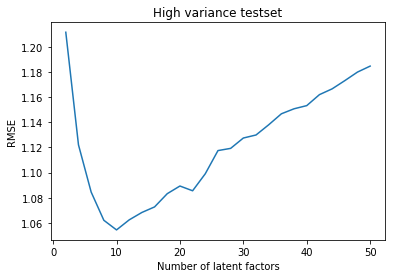

In [87]:
print(res_trim[0][:,0])
print(res_trim[0][:,1])
print(res_trim[0][:,2])
plot_nmf('Number of latent factors', 'RMSE', 'Popular testset', np.linspace(2,50,25), res_trim[0][:,0])
plot_nmf('Number of latent factors', 'RMSE', 'Unpopular testset', np.linspace(2,50,25), res_trim[0][:,1])
plot_nmf('Number of latent factors', 'RMSE', 'High variance testset', np.linspace(2,50,25), res_trim[0][:,2])

#for popular set, c = 16, the smallest rmse = 0.89034711
#for unpopular set, c = 20, the smallest rmse = 1.029
#for high variance set, c = 10, the smallest rmse = 1.05

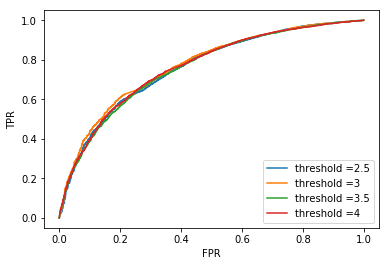

[0.7609147668379248, 0.7705646527973703, 0.758891391177818, 0.7633338034116481]


In [6]:
from sklearn import metrics
from surprise.model_selection import train_test_split
from surprise.prediction_algorithms.matrix_factorization import NMF

def transform_threshold(testset, threshold):
    res = []
    for item in testset:
        
        if item[2] >= threshold:
            res.append(1)
        else:
            res.append(0)
    return np.array(res)

def transform_pred(testpred):
    res = []
    for item in testpred:
        res.append(item[3])
    return np.array(res)

def print_roc(algo, data, thre):
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    trainset, testset = train_test_split(data, test_size = 0.1)   
    algo.fit(trainset)
    #we don't need to threshold the prediction..according to piazza
    test_pred = algo.test(testset)
    test_pred_transformed = transform_pred(test_pred)
    roc_auc = []
    
    #how to compute prob? ...
    for t in thre:
        test_true = transform_threshold(testset, t) 
        fpr, tpr, thresholds = metrics.roc_curve(test_true, test_pred_transformed)
        label = 'threshold =' + str(t)
        plt.plot(fpr, tpr, label = label) 
        roc_auc.append(metrics.auc(fpr, tpr))
    plt.legend(bbox_to_anchor=(1,0), loc = 4)
    plt.show()
    
    print(roc_auc)

print_roc(NMF(n_factors = 20), data_nmf,[2.5,3,3.5,4])    



In [132]:
path = 'ml-latest-small/movies.csv'
movie_data = pd.read_csv(path, names = ['movieid', 'title', 'genre'], header = 0)
id_name = {}
id_genre = {}
for movie_item in movie_data.values:
    id_name[movie_item[0]] = movie_item[1]
    id_genre[movie_item[0]] = movie_item[2]

from sklearn.decomposition import NMF
nmf_model = NMF(n_components=20)
user_dis = nmf_model.fit_transform(R)
item_dis = nmf_model.components_
movie_sorted = np.argsort(-item_dis, axis = 1)[:,:10]
#print(np.sort(-item_dis, axis = 1)[:,:20])
genre_top20 = []
for row in movie_sorted:
    cur_row = []
    for item in row:
        cur_row.append(id_genre[movieids[item]])
    genre_top20.append(cur_row)
    print(cur_row)

#since most movies belong to the genre drama, so we ignore the effect this genre
#for col1 Fantasy, col2 no, col3 Adventure, col4 no, col5 no, col5 Horror/Thriller, col6 Action/Adventure
#col7 children, col8 Horror/Thriller, col9 Action/Adventure, col10 no 
#we can see that the top10 movies from most of the cols belong to a certain type, while some of the columns don't 
#show some patterns.
#We can say that some of the latent factors have close connections with the movie genres.


['Adventure|Fantasy', 'Adventure|Fantasy', 'Action|Adventure|Drama|Fantasy', 'Adventure|Animation|Children|Comedy|Fantasy|Romance', 'Adventure|Animation|Children|Comedy|Fantasy', 'Action|Adventure|Comedy|Fantasy', 'Adventure|Animation|Children|Comedy', 'Action|Adventure|Animation|Children|Comedy', 'Crime|Drama', 'Action|Sci-Fi|Thriller']
['Drama|Romance', 'Drama|Mystery', 'Action|Adventure|Mystery|Romance|Thriller', 'Film-Noir|Mystery', 'Comedy|Romance', 'Drama', 'Comedy|Drama|Romance', 'Mystery|Thriller', 'Comedy|War', 'Crime|Drama']
['Comedy|Drama|Romance|War', 'Thriller', 'Adventure|Drama|Western', 'Adventure|Drama|IMAX', 'Comedy|Crime|Drama|Thriller', 'Action|Adventure|Sci-Fi|Thriller', 'Action|Adventure|Comedy|Romance|Thriller', 'Crime|Horror|Thriller', 'Crime|Drama', 'Action|Drama|War']
['Drama', 'Comedy|Drama', 'Adventure|Drama|Western', 'Drama', 'Action|Drama|Romance|War', 'Children|Drama|Fantasy', 'Drama|Romance|War', 'Drama', 'Comedy|Drama|War', 'Adventure|Animation|Comedy|Fa

In [203]:
from surprise.prediction_algorithms.matrix_factorization import SVD
res_svd = cross_valid_nmf(data_nmf, 10, 'SVD')

[0.8872731878411433, 0.8866822162363894, 0.8873412960220103, 0.888021293808138, 0.8881529301795201, 0.887421134689688, 0.8866136871131378, 0.8871161333150438, 0.88801508312417, 0.8887398986935905, 0.887047799321804, 0.8891668813717513, 0.8883477170119155, 0.8881028916010566, 0.8873473546563687, 0.8884364343076097, 0.888031147641191, 0.8885805244707052, 0.8888749979723519, 0.8891116823065535, 0.889417364507089, 0.8888126957999475, 0.8889707557919729, 0.8876123460067191, 0.8893018766014172]
[0.6834591342408592, 0.6828307248474459, 0.6839183830721216, 0.683327977561697, 0.6836210033966652, 0.6830993643090577, 0.682375113147841, 0.6826908482915153, 0.6835535206542734, 0.6835481574846474, 0.6826379919783898, 0.6838665862234403, 0.6840928086502306, 0.683151842629244, 0.6827537280145769, 0.6839480293686838, 0.6830772776221504, 0.6836448566862314, 0.6841277952582792, 0.6837093562594809, 0.6846932016144206, 0.6835764599496066, 0.6843272312800771, 0.6828079085273343, 0.6836766175305422]


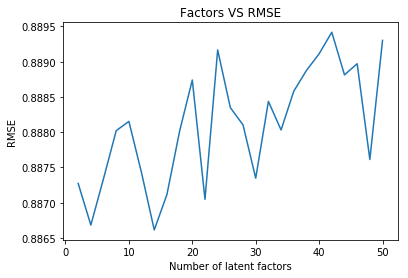

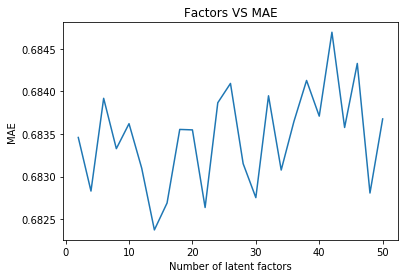

In [205]:
print(res_svd[0])
print(res_svd[1])
plot_nmf('Number of latent factors', 'RMSE', 'Factors VS RMSE',np.linspace(2,50,25), res_svd[0])
plot_nmf('Number of latent factors', 'MAE', 'Factors VS MAE',np.linspace(2,50,25), res_svd[1])
#the best RMSE 0.8866 when k = 14
#the best MAE 0.6823 when k = 14
#optimal number for k is 14

In [137]:
res_trim_svd = cross_valid_nmf_trim(data_nmf, 10, 'SVD')

0
[0.86596594 0.93616309 1.0607478 ]
1
[0.86611628 0.93702814 1.05726126]
2
[0.8641482  0.93790468 1.04812217]
3
[0.86650963 0.93483232 1.05540452]
4
[0.86670368 0.93342637 1.06127961]
5
[0.86539148 0.93683729 1.0499133 ]
6
[0.86548947 0.93737486 1.05558011]
7
[0.86588505 0.93464914 1.0575534 ]
8
[0.8649114  0.93785356 1.05988104]
9
[0.86464307 0.93763386 1.05064741]
10
[0.86452114 0.93858648 1.05812753]
11
[0.86534345 0.93568989 1.05088374]
12
[0.86559876 0.94072315 1.05058288]
13
[0.86422997 0.94131353 1.05174105]
14
[0.86695979 0.93824024 1.05324936]
15
[0.86528592 0.93963079 1.05247049]
16
[0.86440725 0.93904879 1.04853559]
17
[0.86530754 0.93966829 1.05535098]
18
[0.86547582 0.94224124 1.05294712]
19
[0.86455107 0.94277076 1.05620022]
20
[0.86413321 0.94103356 1.06482484]
21
[0.86529198 0.94399724 1.04455317]
22
[0.8663735  0.93842635 1.0490534 ]
23
[0.86575431 0.94090294 1.05216754]
24
[0.86386368 0.94391035 1.05225433]


[0.86596594 0.86611628 0.8641482  0.86650963 0.86670368 0.86539148
 0.86548947 0.86588505 0.8649114  0.86464307 0.86452114 0.86534345
 0.86559876 0.86422997 0.86695979 0.86528592 0.86440725 0.86530754
 0.86547582 0.86455107 0.86413321 0.86529198 0.8663735  0.86575431
 0.86386368]
[0.93616309 0.93702814 0.93790468 0.93483232 0.93342637 0.93683729
 0.93737486 0.93464914 0.93785356 0.93763386 0.93858648 0.93568989
 0.94072315 0.94131353 0.93824024 0.93963079 0.93904879 0.93966829
 0.94224124 0.94277076 0.94103356 0.94399724 0.93842635 0.94090294
 0.94391035]
[1.0607478  1.05726126 1.04812217 1.05540452 1.06127961 1.0499133
 1.05558011 1.0575534  1.05988104 1.05064741 1.05812753 1.05088374
 1.05058288 1.05174105 1.05324936 1.05247049 1.04853559 1.05535098
 1.05294712 1.05620022 1.06482484 1.04455317 1.0490534  1.05216754
 1.05225433]


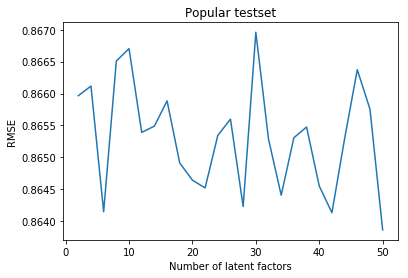

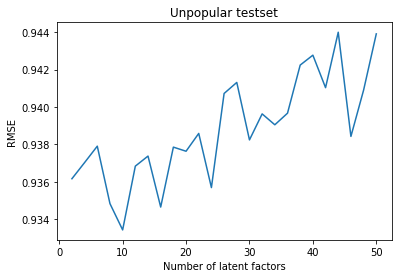

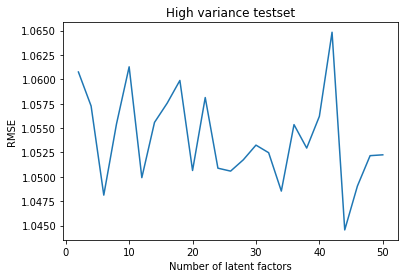

In [138]:
print(res_trim_svd[0][:,0])
print(res_trim_svd[0][:,1])
print(res_trim_svd[0][:,2])
plot_nmf('Number of latent factors', 'RMSE', 'Popular testset', np.linspace(2,50,25), res_trim_svd[0][:,0])
plot_nmf('Number of latent factors', 'RMSE', 'Unpopular testset', np.linspace(2,50,25), res_trim_svd[0][:,1])
plot_nmf('Number of latent factors', 'RMSE', 'High variance testset', np.linspace(2,50,25), res_trim_svd[0][:,2])
#best popular k = 6, 0.864
#best unpopular k = 10, 0.933
#best high variance k = 44, 1.044

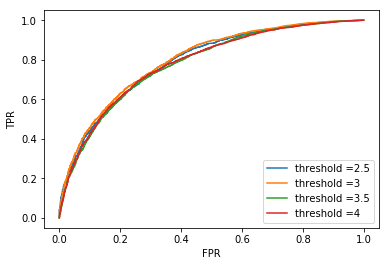

[0.7914340693097344, 0.8000795676022692, 0.7800648736108896, 0.7826265064870965]


In [206]:
print_roc(SVD(n_factors = 14), data_nmf,[2.5,3,3.5,4])
#auc = 0.7788

In [218]:
#part6
from surprise import AlgoBase

class NaiveAlgo(AlgoBase):

    def __init__(self):
        AlgoBase.__init__(self)

    def fit(self, trainset):
        AlgoBase.fit(self, trainset)
        return self

    def estimate(self, u, i):
        if self.trainset.knows_user(u):
            return np.mean([r for (_, r) in self.trainset.ur[u]])
        return 0

algo = NaiveAlgo()
res_naive = cross_validate(algo, data_nmf, measures=['RMSE', 'MAE'], cv=10)
print(np.mean(res_naive['test_rmse']))
        

0.9624558160124576


In [219]:
def cross_valid_naive_trim(data, k):
    kf = KFold(n_splits=k)
    rmse = np.array([0.0]*3)
    algo = NaiveAlgo()
    rmse_cache = []
    for trainset, testset in kf.split(data):
        algo.fit(trainset)
        trimed_set = trim_set(testset)
        pred1 = algo.test(trimed_set[0])
        pred2 = algo.test(trimed_set[1])
        pred3 = algo.test(trimed_set[2])
        rmse_cache.append([accuracy.rmse(pred1, verbose = False), accuracy.rmse(pred2, verbose = False), accuracy.rmse(pred3, verbose = False)])
    return np.mean(np.array(rmse_cache), 0)

naive_rmse = cross_valid_naive_trim(data_nmf, 10)
print(naive_rmse)

[0.94827552 0.99457736 1.13985929]


Computing the msd similarity matrix...
Done computing similarity matrix.


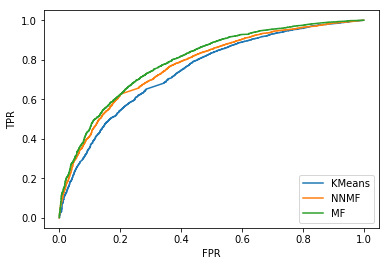

[0.7454362691735876, 0.7742141879547884, 0.7952686630231407]


In [7]:
#part7
#qustion34
from surprise.prediction_algorithms.matrix_factorization import NMF
from surprise.prediction_algorithms.matrix_factorization import SVD
from surprise.prediction_algorithms.knns import KNNBasic

def plot_roc_summary(data):
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    
    #autually I don't know the optimal knn parameters
    #need to refer to question4
    algos = [['KMeans', KNNBasic(k = 22)],['NNMF', NMF(n_factors = 20)], ['MF', SVD(n_factors = 14)]]   
    trainset, testset = train_test_split(data, test_size = 0.1)  
    test_true = transform_threshold(testset, 3) 
    roc_auc = []
    
    for lab, algo in algos:   
        algo.fit(trainset)
        test_pred = algo.test(testset)
        test_pred_transformed = transform_pred(test_pred)
        fpr, tpr, thresholds = metrics.roc_curve(test_true, test_pred_transformed)
        label = lab
        plt.plot(fpr, tpr, label = label) 
        roc_auc.append(metrics.auc(fpr, tpr))
    plt.legend(bbox_to_anchor=(1,0), loc = 4)
    plt.show()
    
    print(roc_auc)
    
plot_roc_summary(data_nmf)
    